In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [17]:
import src.config as config
from src.inference import (
    get_feature_store
)

from datetime import datetime, timezone, timedelta

def get_current_utc_hour_ceiled():
    """Get current UTC time ceiled to the next hour"""
    current = datetime.now(timezone.utc)
    if current.minute > 0 or current.second > 0:
        # Ceil to next hour
        current = current + timedelta(hours=1)

    # Reset minutes, seconds, and microseconds
    current = current.replace(minute=0, second=0, microsecond=0)
    return current

# Usage
current_hour = get_current_utc_hour_ceiled()
print(f"Current UTC hour (ceiled): {current_hour}")

Current UTC hour (ceiled): 2025-05-10 12:00:00+00:00


In [18]:
def fetch_predictions():
    current_date = pd.Timestamp.now(tz='Etc/UTC').ceil('h')

    fs = get_feature_store()
    fg = fs.get_feature_group(
        name=config.FEATURE_GROUP_MODEL_PREDICTION,
        version=1
    )

    query = fg.select_all()
    query = query.filter(fg.pickup_hour == current_hour)

    return query.read()

In [26]:
from hsfs.client.exceptions import RestAPIError

try:
    fg = fs.get_feature_group(name=config.FEATURE_GROUP_MODEL_PREDICTION, version=1)
    print("✅ Feature group found.")
except RestAPIError:
    print("❌ Feature group not found. Check name or create it first.")
    fg = None


✅ Feature group found.


2025-05-10 07:20:27,350 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-10 07:20:27,356 INFO: Initializing external client
2025-05-10 07:20:27,356 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 07:20:28,081 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1228966
✅ Connected to Hopsworks.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


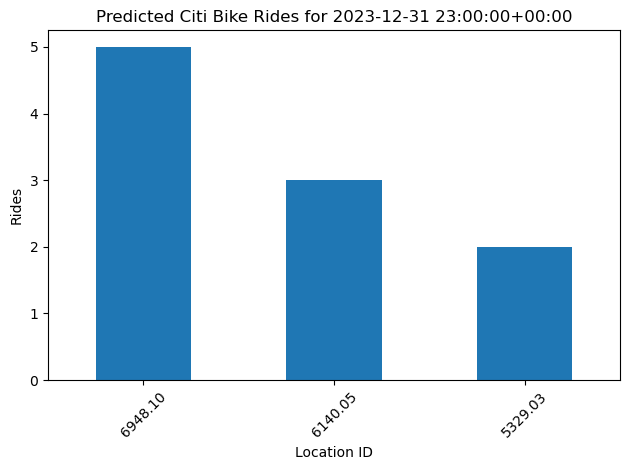

,pickup_location_id,pickup_hour,predicted_rides
15189,6948.10,2023-12-31 23:00:00+00:00,5
24002,6140.05,2023-12-31 23:00:00+00:00,3
2868,5329.03,2023-12-31 23:00:00+00:00,2


In [29]:
# 17_fetch_predictions.ipynb

import pandas as pd
import hopsworks
import src.config as config

# Step 1: Login to Hopsworks
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY,
)
fs = project.get_feature_store()
print("✅ Connected to Hopsworks.")

# Step 2: Access the predictions Feature Group
fg = fs.get_feature_group(
    name=config.FEATURE_GROUP_MODEL_PREDICTION,
    version=config.FEATURE_GROUP_MODEL_PREDICTION_VERSION,
)

# Step 3: Read recent prediction data
df = fg.read()
df["pickup_hour"] = pd.to_datetime(df["pickup_hour"])
df["pickup_location_id"] = df["pickup_location_id"].astype(str)
df["predicted_rides"] = df["predicted_rides"].astype(int)

# Step 4: Display the latest predictions
latest_hour = df["pickup_hour"].max()
recent_preds = df[df["pickup_hour"] == latest_hour].sort_values("predicted_rides", ascending=False)

import matplotlib.pyplot as plt

# Optional: Quick bar plot
recent_preds.plot(
    x="pickup_location_id", 
    y="predicted_rides", 
    kind="bar", 
    title=f"Predicted Citi Bike Rides for {latest_hour}", 
    legend=False
)
plt.ylabel("Rides")
plt.xlabel("Location ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display top rows
recent_preds.head()


In [32]:
df

,pickup_location_id,pickup_hour,predicted_rides
0,6948.10,2023-11-23 05:00:00+00:00,2
1,5329.03,2023-04-29 04:00:00+00:00,0
2,6948.10,2023-06-04 23:00:00+00:00,1
3,6140.05,2023-02-27 09:00:00+00:00,28
4,6948.10,2023-09-22 18:00:00+00:00,36
...,...,...,...
24514,6140.05,2023-06-19 16:00:00+00:00,43
24515,5329.03,2023-04-10 05:00:00+00:00,2
24516,6140.05,2023-12-21 01:00:00+00:00,1
24517,6948.10,2023-09-13 00:00:00+00:00,5


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24519 entries, 0 to 24518
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   pickup_location_id  24519 non-null  object                 
 1   pickup_hour         24519 non-null  datetime64[us, Etc/UTC]
 2   predicted_rides     24519 non-null  int64                  
dtypes: datetime64[us, Etc/UTC](1), int64(1), object(1)
memory usage: 574.8+ KB


In [37]:
df["pickup_hour"].max()

Timestamp('2023-12-31 23:00:00+0000', tz='Etc/UTC')